In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import random
import sys
import matplotlib.colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.linear_model import LinearRegression
import sys, os
sys.path.insert(0, os.path.abspath('../utils'))
from MastodonFunctions import xml_features, csv_features, ordering_tracks, smoothing_filter, peak_detection, bulk_peak_analysis

# Figure 2 - in vitro

In vitro data for generating figure 2. 

Import the data for the in vitro experiments: number of peaks according to the area in the PSM where the cells were taken from. 
For each experiment (columns) we have the number of cells (rows) that performs from 0-9 number of peaks. 

In [2]:
invitro_data = pd.read_excel('../Data/Figure 2/Figure 2 - In vitro/Fig2_PSM4_number_of_peaks_checked.xlsx', header=[0])
invitro_data.head() 

,Unnamed: 0,Unnamed: 1,1,2,3,4,5,6,7,8,9,total cells
0,HL 450,PSM4,0,1,5,7,4,0,0,1,0,18
1,HL449,PSM4,0,1,4,6,4,5,2,2,0,24
2,HL 419,PSM4,2,0,2,3,0,2,0,0,0,9
3,HL 421,PSM4,0,1,1,4,6,1,2,1,0,16
4,HL420,PSM4,0,2,1,2,1,1,0,0,0,7


### Plot of percentage of cells versus peak number in the PSMd Area

In [3]:
# Obtain the number of cells that perform 1-9 peaks

# Total number of cells
total_cells = invitro_data['total cells'].to_numpy()[-1]

aux1 = []
aux2 = []

for i in range(1,10):
    # Number of cells per peak i
    aux1.append(invitro_data[i].to_numpy()[-1])
    
    # Percentage of cells per peak i
    aux2.append(invitro_data[i].to_numpy()[-1]*100/total_cells)

# Convert it into a DataFrame for the plotting with pandas
percent_cells_pd1 = pd.DataFrame({'Total': aux1})
percent_cells_pd2 = pd.DataFrame({'Total %': aux2})

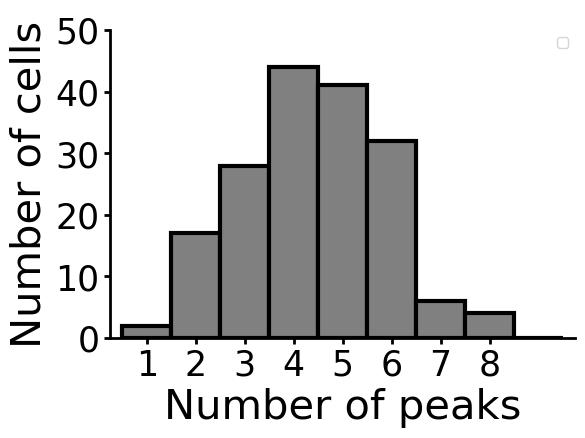

Mean: 4.40805
Standard Deviation: 1.62527


In [4]:
fig, ax = plt.subplots(figsize=[6,4])

percent_cells_pd1.plot.bar(rot=0, subplots=True, color='gray', edgecolor='black', 
                           linewidth=3, width=1, ax=ax)
plt.xticks([0,1,2,3,4,5,6,7],[1,2,3,4,5,6,7,8], fontsize=25)
plt.yticks(fontsize=25)
plt.legend([])
plt.xlabel('Number of peaks', fontsize=30)
plt.ylabel('Number of cells', fontsize=30)
plt.ylim([0,50])
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)
plt.title(' ')
plt.show()

fig.savefig('../Data/Figure 2/Figure 2 - In vitro/Results/PeakHistogram-invitro.pdf', format='pdf', bbox_inches='tight')

print('Mean: %g'%np.average(np.arange(1,10,1), weights=percent_cells_pd2['Total %']))
print('Standard Deviation: %g'%np.sqrt(np.cov(np.arange(1,10,1), aweights=percent_cells_pd2['Total %'])))

### Calculate successive peak ratio 
$Period[t+1]/Period[t]$

In [5]:
invitro_data = pd.read_excel('../Data/Figure 2/Figure 2 - In vitro/Fig2_MaxInt&PeriodSucesiveRatio_checked.xlsx', 
                             sheet_name = 'Period Successive Ratios',header=[2])
invitro_data.head()

,Cell Position,41,43,47,48,54,56,68,70,73,...,25,26.2,27.2,29,33.1,34.2,35,36,38.2,39.1
0,cycle 2 / 1,1.240965,NaN,1.077558,0.806463,1.104773,1.331926,1.094687,1.127732,NaN,...,1.290985,1.057834,0.936142,0.994097,1.123847,0.990214,1.172602,1.508959,0.881187,1.299518
1,cycle 3/2,1.215691,NaN,1.207229,1.575845,1.142003,1.061466,NaN,NaN,NaN,...,1.003052,1.016947,NaN,1.004252,1.004736,1.146637,1.137207,NaN,1.569998,NaN
2,cycle 4/3,1.102287,NaN,NaN,0.921607,NaN,NaN,NaN,NaN,NaN,...,1.118174,1.243114,NaN,1.296342,1.162273,1.163856,1.157516,NaN,1.049723,NaN
3,cycle 5/4,1.143218,NaN,NaN,1.166043,NaN,NaN,NaN,NaN,NaN,...,NaN,1.017644,NaN,1.238767,1.107472,1.085171,1.072567,NaN,NaN,NaN
4,cycle 6/5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.830081,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Organize the data

cells = invitro_data.keys()[1:]
successive_ratios = []

for i in cells:
    if type(i) == int:
        successive_ratios += list(invitro_data[i].dropna().to_numpy())

In [7]:
# Remove ouliers from a list
def reject_outliers(data, m=3):
    return data[abs(data - np.nanmean(data)) < m * np.nanstd(data)]

# Find differences between two lists
def Diff(li1, li2): 
    return (list(set(li1) - set(li2)))

# Remove outliers from the ratio array
ratios = reject_outliers(np.array(successive_ratios))

# Outliers
ratio_outliers = Diff(np.array(successive_ratios), ratios)

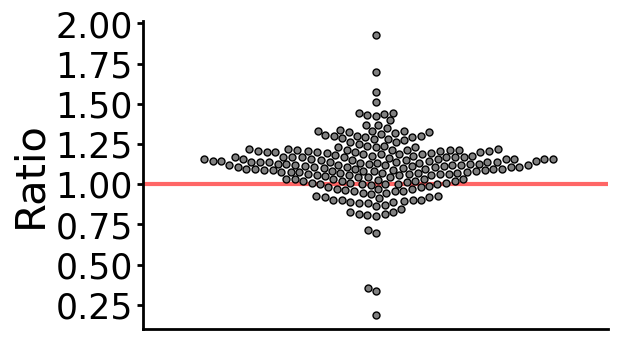

Mean: 1.10997
Standard Deviation: 0.185131


In [8]:
plt.style.use('default')
fig = plt.figure(figsize=[6,4])
sns.swarmplot(data=ratios, orient='v', color='gray',  size=5, edgecolor='black', linewidth=1, zorder=1)
plt.axhline(1, linewidth=3, color='red', alpha=0.6, zorder=0)
plt.xticks([], fontsize=25)
plt.yticks(fontsize=25)
plt.ylabel('Ratio', fontsize=30)
#plt.ylim([0,2.1])

ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)
plt.show()

fig.savefig('../Data/Figure 2/Figure 2 - In vitro/Results/PerdioRatio-invitro.pdf', format='pdf', bbox_inches='tight')

print('Mean: %g'%np.mean(ratios))
print('Standard Deviation: %g'%np.std(ratios))

### Mesp intensity analysis

In [9]:
# Fluorescent traces of mKate and last peaks of Her 1
mesp_intensities_df = pd.read_excel('../Data/Figure 2/Figure 2 - In vitro/Fig2_LastPeakPSM4_&_MespInt_checked.xlsx', 
                                sheet_name='Mesp Intensity', header=[0,1])
# Drop empty columns
mesp_intensities_df = mesp_intensities_df[mesp_intensities_df.columns.dropna()]

last_peaks_df = pd.read_excel('../Data/Figure 2/Figure 2 - In vitro/Fig2_LastPeakPSM4_&_MespInt_checked.xlsx', 
                                sheet_name='Last Peak', header=[0,1])
# Drop empty columns
last_peaks_df = last_peaks_df[last_peaks_df.columns.dropna()]

cells_id = []
intensities_mesp = []
last_peak_her1 = []

# Temporal resolution
tr = 10 # minutes

experiments_id = []
cells_id = []
for i in range(1,len(mesp_intensities_df.keys())):
    if type(mesp_intensities_df.keys()[i][1]) == int:
        experiments_id.append(mesp_intensities_df.keys()[i][0])
        cells_id.append(mesp_intensities_df.keys()[i][1])

for i,val in enumerate(cells_id):
    
    exp = experiments_id[i]
        
    intensities_mesp.append(mesp_intensities_df[exp][val].dropna().to_numpy())
    last_peak_her1.append(last_peaks_df[exp][val].dropna().to_numpy())
    

        

In [10]:
# Number of cells in all the experiments
print('There are %d cells for the PSM4, in vitro from %d experiments'%(len(cells_id), len(experiments_id)))

There are 174 cells for the PSM4, in vitro from 174 experiments


### Mesp Traces

The in vitro experiments are formed by 11 different experiments and in each of these experiments we have several cells. The figure below represents all of these experiments. 

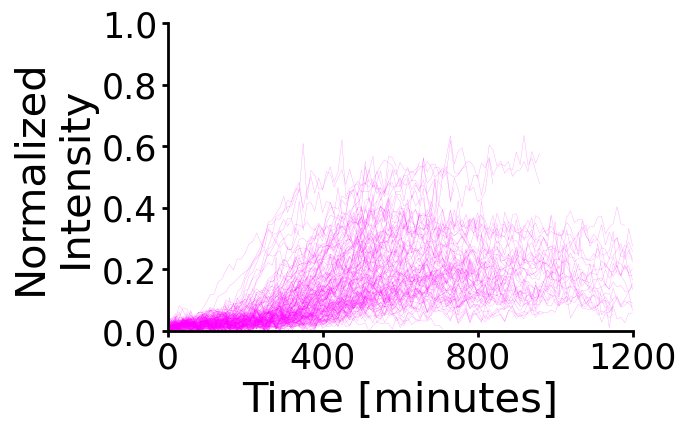

In [11]:
fig = plt.figure(figsize=[6,4])
for i in range(len(cells_id)):
    plt.plot(np.arange(len(intensities_mesp[i]))*tr, 
             (intensities_mesp[i]-np.min(intensities_mesp[i]))/np.max(intensities_mesp[i]),
            color = 'magenta', linewidth=0.2, alpha=0.5)
    
plt.xlim([0,1200])
plt.ylim([0,1])
plt.xticks(np.arange(0,1600,400), fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel('Time [minutes]', fontsize=30)
plt.ylabel('Normalized\nIntensity', fontsize=30)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.show()

fig.savefig('../Data/Figure 2/Figure 2 - In vitro/Results/MespTracesAll.pdf', format='pdf', bbox_inches='tight')

## Align according to last peak

In order to better analyze Mesp data, we will first align the data according to Her 1 las peak (which will be our reference time to compare in vivo and in vitro data). However, we will use the data from the beginning of the movie, all the way until 2 hours after the last peak. 

### Last-peak alignment 

#### Mesp traces with the windows marked for fold change analysis

In black dashed lines, you have the lines that define the regions used to make the fold change analysis performed below. 

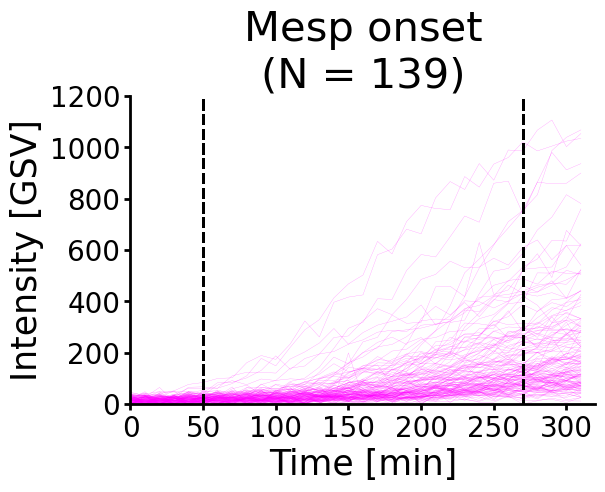

In [19]:
# Plot all Mesp tracks for each experiment separately

# Define the dimensions of the subplot

# Initialize the figure size
fig = plt.figure(figsize=[6,4])
    
window = 5

# start at time = 0, stop at time = last peak time + 2 hours
cut_off_val1 = 160 # in minutes --> Stop time
cut_off_val2 = 160 # in minutes --> Start time

len_traces = (cut_off_val1+cut_off_val2)//tr
# Save cropped values of intensity mesp
intensities_mesp_lp = []

# Save the initial mean values per each experiment to later detrend
mean_vals_exp = []

# Save the last peak values in minutes
last_peak_lp = []

# To know how many mesp we have and how many meso traces we will actually use
mesp_counter = 0
mesp_all_counter = 0

# For plotting: mesp traces starting on a similar region and normalized by max
intensities_mesp_lp_plot = []

for j in range(len(cells_id)):
    
    aux = []
    
    mesp_all_counter += 1

    # Find the last peak
    #CH CHANGE TO AVOID NUMPY DEPRECATION WARNING
    #ind2 = int(last_peak_her1[j]/tr) # peaks is in minutes, convert into time frames
    ind2 = int(last_peak_her1[j][0]/tr) # peaks is in minutes, convert into time frames
    stop_time = ind2+int(cut_off_val1/tr) # We have it in frames, not in minutes! 
    start_time = ind2-int(cut_off_val2/tr)

    # Check if there are enough values before and after the last peak
    if start_time>0:

        # Crop the Mesp traces
        intensities = intensities_mesp[j][start_time:stop_time]
        
        # Check if all the values are not nan
        if np.count_nonzero(~np.isnan(intensities)) == len_traces:

            mesp_counter += 1
            aux.append(intensities[0])
            # Save cropped values of mesp
            intensities_mesp_lp.append(intensities)
            last_peak_lp.append(last_peak_her1[j]) # This is already in minutes!
            
            # Save cropped values of mesp
            intensities_mesp_lp_plot.append((intensities-np.min(intensities)))
            
            plt.plot(intensities-np.min(intensities),
                     color='magenta', linewidth=0.2, alpha=0.5)
                
            plt.xticks(np.arange(0,len_traces+5,5), map(int, np.arange(0,len_traces+5,5)*tr), fontsize=20)
            plt.xlim([0,len_traces])
            plt.yticks(fontsize=20)
            plt.ylim([0,1200])
            plt.xlabel('Time [min]', fontsize=25)
            plt.ylabel('Intensity [GSV]', fontsize=25)
            
            plt.axvline(window, color='black', linewidth=2, linestyle='--')
            plt.axvline(len_traces-window, color='black', linewidth=2, linestyle='--')

            ax = plt.gca()
            ax.tick_params(width=2, length=4)
            ax.spines['top'].set_linewidth(0)
            ax.spines['bottom'].set_linewidth(2)
            ax.spines['left'].set_linewidth(2)
            ax.spines['right'].set_linewidth(0)
            
plt.title('Mesp onset\n(N = %d)'%(len(intensities_mesp_lp_plot)), fontsize=30)        
plt.show()

fig.savefig('../Data/Figure 2/Figure 2 - In vitro/Results/MespTraces-Cropped.pdf', format='pdf', bbox_inches='tight')

In [20]:
print('In total there are: %d Mesp Traces'%mesp_all_counter)
print('But the ones that satisfy the required temporal length are: %d'%mesp_counter)

In total there are: 174 Mesp Traces
But the ones that satisfy the required temporal length are: 139


### Calculate Mesp fold change

In [21]:
# How many points to take into account for the average of Area 1 and 2

exp = 0

def ratio_mesp(window, intensities):
        
    # Compute the areas
    area1 = np.abs(np.mean(intensities[:window]))
    area2 = np.mean(intensities[-window:])

    # Compute the fold change
    ratio = area2 - area1
    
    return ratio

# Compute the fold change: Area 2 - Area 1 
ratio = []


window = 5

for i in range(len(intensities_mesp_lp)):
       
        # Intensity values of Mesp tracks
        intensities = intensities_mesp_lp[i]

        ratio.append(ratio_mesp(window, intensities))
    

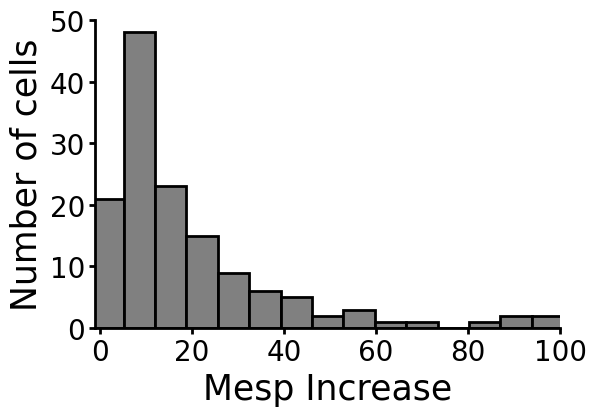

In [22]:
# Distributions

fig = plt.figure(figsize=[6,4])


plt.hist(ratio, edgecolor='black', color='gray', bins='fd', linewidth=2)
plt.xlabel('Mesp Increase', fontsize=25)
plt.ylabel('Number of cells', fontsize=25)
plt.xticks(np.arange(0,1200,200), np.arange(0,120,20), fontsize=20)
plt.yticks(fontsize=20)
plt.xlim([-10,1000])
plt.ylim([0,50])

ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.show()

fig.savefig('../Data/Figure 2/Figure 2 - In vitro/Results/FoldChangeMesp-LastPeak.pdf', format='pdf', bbox_inches='tight')

## Perform the Fold Change distributions for her1 and Mesp

### Classify Mesp fold change values

In order to make the distributions to observe how is the Mesp onset with respect the last peak of her 1, we first need to classify the fold change (which we calculated above) in terms of how high is this fold change. In the end, for the distribution analysis, we will only be using cells which have a clear Mesp onset. Which is why, in the following lines we will first classify using supervised machine learning algorthm K-Means to cluster the Mesp Fold Change values. 

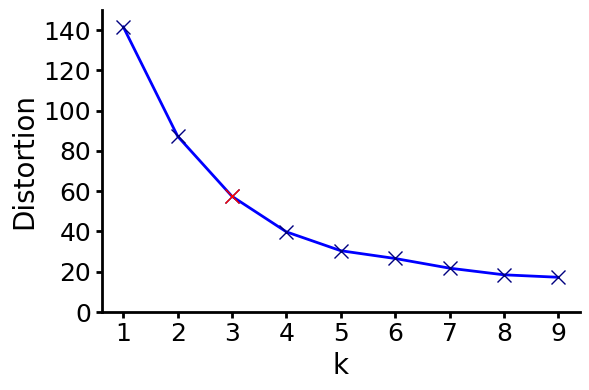

In [23]:
# k means determine k: ELBOW METHOD
from scipy.spatial.distance import cdist


fig = plt.figure(figsize=[6,4])

    
distortions = []
K = range(1,10)

# Define the data
X = np.array(ratio).reshape(-1, 1)
X[np.where(np.isnan(X))] = 0 # In case there is any nan

for k in K:
    kmeanModel = KMeans(n_clusters=k, n_init=100).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-', linewidth=2, markersize=10,  mec='navy')
plt.plot(3, distortions[2], 'bx-', linewidth=6, markersize=10,  mec='red')
plt.xlabel('k', fontsize=20)
plt.ylabel('Distortion', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim([0, 150])
#plt.title('The Elbow Method showing the optimal k', fontsize=20)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)
    
plt.tight_layout()
plt.show()

fig.savefig('../Data/Figure 2/Figure 2 - In vitro/Results/ElbowMethod.pdf', bbox_inches='tight')

In [24]:
# SILHOUETTE METHOD

from sklearn.metrics import silhouette_samples, silhouette_score


range_n_clusters = [2, 3, 4, 5]

    
for n_clusters in range_n_clusters:

    # Define the data
    X = np.array(ratio).reshape(-1, 1)
    X[np.where(np.isnan(X))] = 0 # In case there is any nan

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, n_init=50)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is : %.2f"%silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

For n_clusters = 2 The average silhouette_score is : 0.74
For n_clusters = 3 The average silhouette_score is : 0.67
For n_clusters = 4 The average silhouette_score is : 0.64
For n_clusters = 5 The average silhouette_score is : 0.60


### Classify using K-means

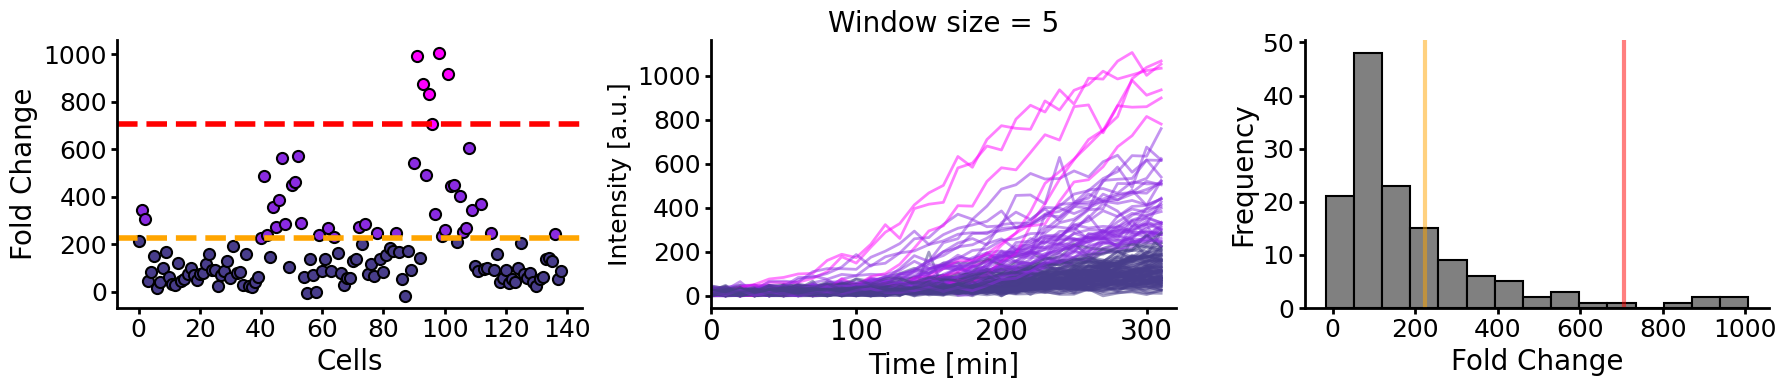

In [25]:
# Distributions

fig = plt.figure(figsize=[18,4])
plt.style.use('default')

n_clusters = 3

plt.subplot(131)
# Calculate the percentage of Mesp on cells

# Remove nans
ratio1_ = np.array(ratio)
    
color = ['darkslateblue', 'magenta', 'blueviolet']
# Use the same seed to avoid changing clusters 
# Define the data
X = np.array(ratio1_).reshape(-1, 1)
X[np.where(np.isnan(X))] = 0 # In case there is any nan
y_pred1 = KMeans(n_clusters=n_clusters, n_init=200, random_state=1).fit_predict(X)

group1 = np.where(y_pred1==1)[0]
group2 = np.where(y_pred1==2)[0]
group3 = np.where(y_pred1==0)[0]

val1 = np.min(ratio1_[group1])
val2 = np.min(ratio1_[group2])
val3 = np.min(ratio1_[group3])

th1 = np.mean(ratio1_<= val1)*100
th2 = np.mean(ratio1_<= val2)*100
th3 = np.mean(ratio1_<= val3)*100

for i in range(len(X)):
    plt.plot(i, X[i], 'o', markersize=8, markerfacecolor=color[y_pred1[i]], markeredgewidth=1.5, markeredgecolor='black')

plt.axhline(val1, color='red', linewidth=4, linestyle='--')
plt.axhline(val2, color='orange', linewidth=4, linestyle='--')
#plt.axhline(val3, color='gold', linewidth=2, linestyle='--')

plt.xlabel('Cells', fontsize=20)
plt.ylabel('Fold Change', fontsize=20)
#plt.ylim([-10,110])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.subplot(132)
count = 0
for i in range(len(intensities_mesp_lp_plot)):   
    plt.plot(intensities_mesp_lp_plot[i], c=color[y_pred1[count]],alpha=0.5, linewidth=2) 
    count+=1
        
plt.xlabel('Time [min]',fontsize=20)
locs, labels = plt.xticks()
plt.xticks(np.arange(0,len_traces+10,10), np.arange(0,len_traces+10,10)*tr, fontsize=20)
plt.xlim([0,len_traces])
plt.yticks(fontsize=18)
plt.ylabel('Intensity [a.u.]',fontsize=18)
plt.title('Window size = %d'%window, fontsize=20)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.subplot(133)

plt.hist(ratio1_, edgecolor='black', color='grey', bins='fd', linewidth=1.5)
plt.axvline(val1, color='red', linewidth=3, alpha=0.5)
plt.axvline(val2, color='orange', linewidth=3, alpha=0.5)
#plt.axvline(val3, color='gold', linewidth=3, alpha=0.5)

plt.xlabel('Fold Change', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)



plt.tight_layout()
plt.show()

fig.savefig('../Data/Figure 2/Figure 2 - In vitro/Results/ClusteredKMeans.pdf', format='pdf', bbox_inches='tight')

In [26]:
print('Percentage of cells in group 1: %.2f'%(len(group1)*100/sum([len(group1),len(group2),len(group3)])))
print('Percentage of cells in group 2: %.2f'%(len(group2)*100/sum([len(group1),len(group2),len(group3)])))
print('Percentage of cells in group 3: %.2f'%(len(group3)*100/sum([len(group1),len(group2),len(group3)])))

Percentage of cells in group 1: 4.32
Percentage of cells in group 2: 25.90
Percentage of cells in group 3: 69.78


In [27]:
print('Percentage of cells with Mesp ON: %.2f'%(4.32+25.90))

Percentage of cells with Mesp ON: 30.22


### Fold Change vs Traces

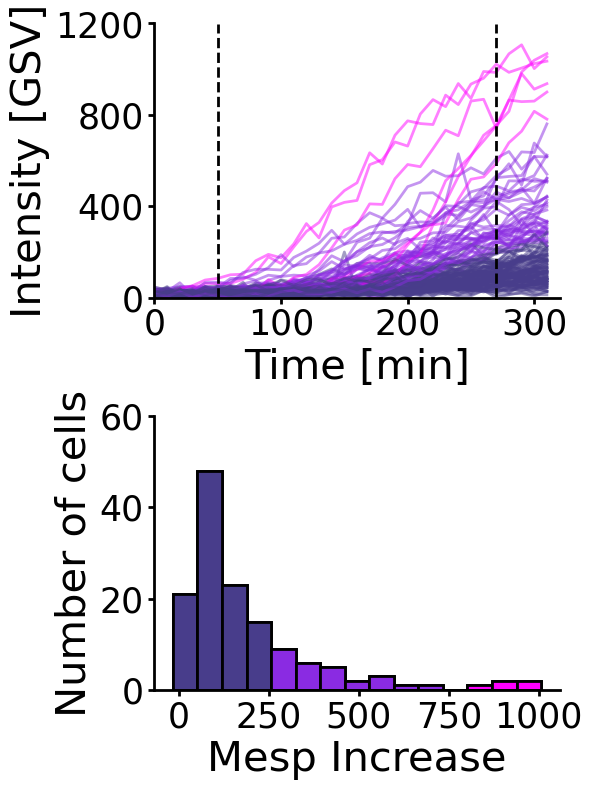

In [28]:
# Distributions

fig = plt.figure(figsize=[6,8])
color = ['darkslateblue', 'magenta', 'blueviolet']
n_clusters = 3

plt.subplot(211)
window = 5
count = 0
for i in range(len(intensities_mesp_lp_plot)):   
    plt.plot(intensities_mesp_lp_plot[i], c=color[y_pred1[count]],alpha=0.5, linewidth=2) 
    count+=1
        
plt.axvline(window, color='black', linewidth=2, linestyle='--')
plt.axvline(len_traces-window, color='black', linewidth=2, linestyle='--')
plt.xlabel('Time [min]',fontsize=30)
locs, labels = plt.xticks()
plt.xticks(np.arange(0,len_traces+10,10), np.arange(0,len_traces+10,10)*tr, fontsize=25)
plt.xlim([0,len_traces])
plt.yticks(np.arange(0,1500,400), fontsize=25)
plt.ylim([0,1200])
plt.ylabel('Intensity [GSV]',fontsize=30)
#plt.title('Window size = %d'%window, fontsize=20)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.subplot(212)

plt.hist(ratio1_, edgecolor='black', color='gray', bins='fd', linewidth=2)
#plt.axvline(val1, color='red', linewidth=3, alpha=0.5)
#plt.axvline(val2, color='red', linewidth=3, alpha=0.5)
N, bins, patches = plt.hist(ratio1_, edgecolor='black', linewidth=2, bins='fd')
#plt.hist(ratio1_, edgecolor='black', color='gray', bins='fd', linewidth=2)
ind1 = np.argmin((val1-bins)**2)
ind2 = np.argmin((val2-bins)**2)

for i in range(0,ind2):
    patches[i].set_facecolor(color[0])
for i in range(ind2,ind1):    
    patches[i].set_facecolor(color[2])
for i in range(ind1, len(patches)):
    patches[i].set_facecolor(color[1])

plt.xlabel('Mesp Increase', fontsize=30)
plt.ylabel('Number of cells', fontsize=30)
plt.xticks(np.arange(0,1250, 250), fontsize=25)
plt.yticks(np.arange(0,80,20), fontsize=25)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)


plt.tight_layout()
plt.show()

fig.savefig('../Data/Figure 2/Figure 2 - In vitro/Results/ClusteredKMeans-FoldChangeMesp.pdf', format='pdf', bbox_inches='tight')

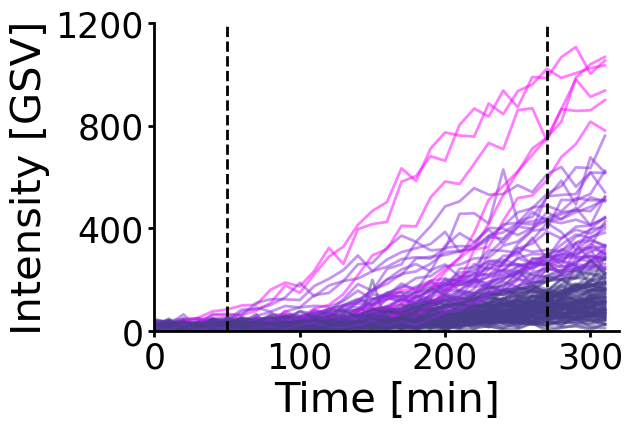

In [29]:
# Distributions

fig = plt.figure(figsize=[6,4])
color = ['darkslateblue', 'magenta', 'blueviolet']
n_clusters = 3

window = 5
count = 0
for i in range(len(intensities_mesp_lp_plot)):   
    plt.plot(intensities_mesp_lp_plot[i], c=color[y_pred1[count]],alpha=0.5, linewidth=2) 
    count+=1
        
plt.axvline(window, color='black', linewidth=2, linestyle='--')
plt.axvline(len_traces-window, color='black', linewidth=2, linestyle='--')
plt.xlabel('Time [min]',fontsize=30)
locs, labels = plt.xticks()
plt.xticks(np.arange(0,len_traces+10,10), np.arange(0,len_traces+10,10)*tr, fontsize=25)
plt.xlim([0,len_traces])
plt.yticks(np.arange(0,1500,400), fontsize=25)
plt.ylim([0,1200])
plt.ylabel('Intensity [GSV]',fontsize=30)
#plt.title('Window size = %d'%window, fontsize=20)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)


plt.show()

fig.savefig('../Data/Figure 2/Figure 2 - In vitro/Results/ClusteredKMeans-MespIncrease-Traces.pdf', format='pdf', bbox_inches='tight')

### In cells with with Mesp on, when is this happening?

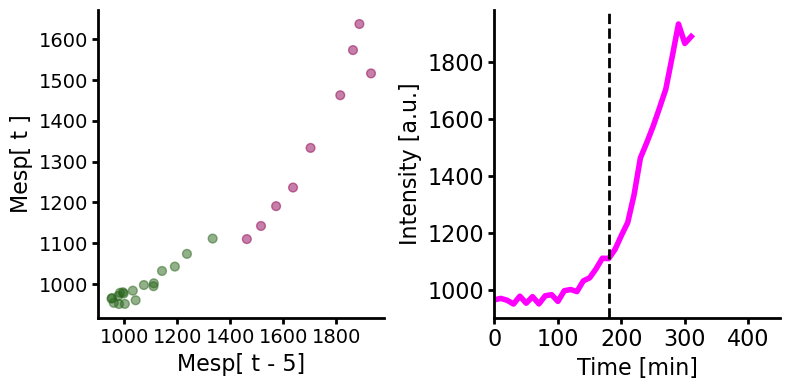

In [30]:
i = np.where(y_pred1==1)[0][1]

X = np.zeros((len(intensities_mesp_lp[i][window:]),2))
X[:,0] = intensities_mesp_lp[i][window:]
X[:,1] = intensities_mesp_lp[i][:-window]
y_pred = KMeans(n_clusters=2, n_init=100).fit_predict(X)

plt.figure(figsize=[8,4])
plt.subplot(121)
plt.scatter(X[:,0], X[:,1], c=y_pred,alpha=0.5,cmap='PiYG',s=40)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Mesp[ t - %d]'%window, fontsize=16)
plt.ylabel('Mesp[ t ]', fontsize=16)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.subplot(122)
ind_cut = np.where(y_pred[5:]==y_pred[-1])[0]+5
plt.plot(intensities_mesp_lp[i], color='magenta', linewidth=4)
plt.axvline(ind_cut[0], color='black', linewidth=2, linestyle='dashed')

plt.xlabel('Time [min]',fontsize=16)
locs, labels = plt.xticks()
plt.xticks(locs, map(int,np.round(locs*tr)), fontsize=16)
plt.xlim(0,45)
plt.yticks(fontsize=16)
plt.ylabel('Intensity [a.u.]',fontsize=16)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.tight_layout()
plt.show()

fig.savefig('../Data/Figure 2/Figure 2 - In vitro/Results/ExampleCell-MespOnset.pdf', format='pdf', bbox_inches='tight')

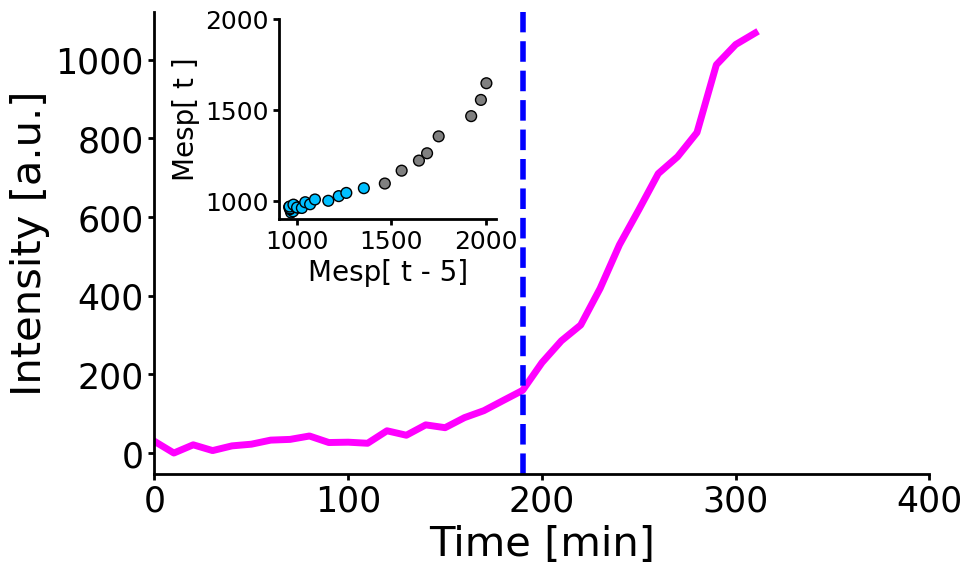

In [31]:
fig = plt.figure(figsize=(10, 6),facecolor='white')
ax = fig.add_subplot(111)

i = np.where(y_pred1==1)[0][5]

window = 5

X = np.zeros((len(intensities_mesp_lp[i][window:]),2))
X[:,0] = intensities_mesp_lp[i][window:]
X[:,1] = intensities_mesp_lp[i][:-window]
y_pred = KMeans(n_clusters=2, n_init=100).fit_predict(X)

ind_cut = np.where(y_pred[5:]==y_pred[-1])[0]+5
plt.plot(intensities_mesp_lp[i]-np.min(intensities_mesp_lp[i]), color='magenta', linewidth=5)
plt.axvline(ind_cut[0], color='blue', linewidth=4, linestyle='dashed')

plt.xlabel('Time [min]',fontsize=30)
plt.xticks(np.arange(0, 50,10),np.arange(0, 50,10)*tr, fontsize=25)
plt.xlim([0,40])
plt.yticks(fontsize=25)
plt.ylabel('Intensity [a.u.]',fontsize=30)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

# this is an inset axes over the main axes
inset_axes_ = inset_axes(ax, 
                    width="28%", # width = 30% of parent_bbox
                    height=2, # height : 1 inch
                    bbox_to_anchor=(-0.55, 0, 1, 1),#bbox_to_anchor=(-0.05, -0.35, 1, 1),
                    bbox_transform=ax.transAxes)

cmap_m = matplotlib.colors.ListedColormap(['grey', 'deepskyblue'])
plt.scatter(X[:,0], X[:,1], c=y_pred,alpha=1,cmap=cmap_m,s=60,edgecolors='k')

plt.xticks(np.arange(1000, 2250,500), fontsize=18)
plt.yticks(np.arange(1000, 2250,500),fontsize=18)
plt.xlabel('Mesp[ t - %d]'%window, fontsize=20)
plt.ylabel('Mesp[ t ]', fontsize=20)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)


plt.show()

fig.savefig('../Data/Figure 2/Figure 2 - In vitro/Results/ExampleCell-MespOnset.pdf', format='pdf', bbox_inches='tight')

#### Show Mesp Onset for each individual cell

The colors are according to the group they belong which was calculated using K-Means Clustering (above figures) with 3 different clusters. 

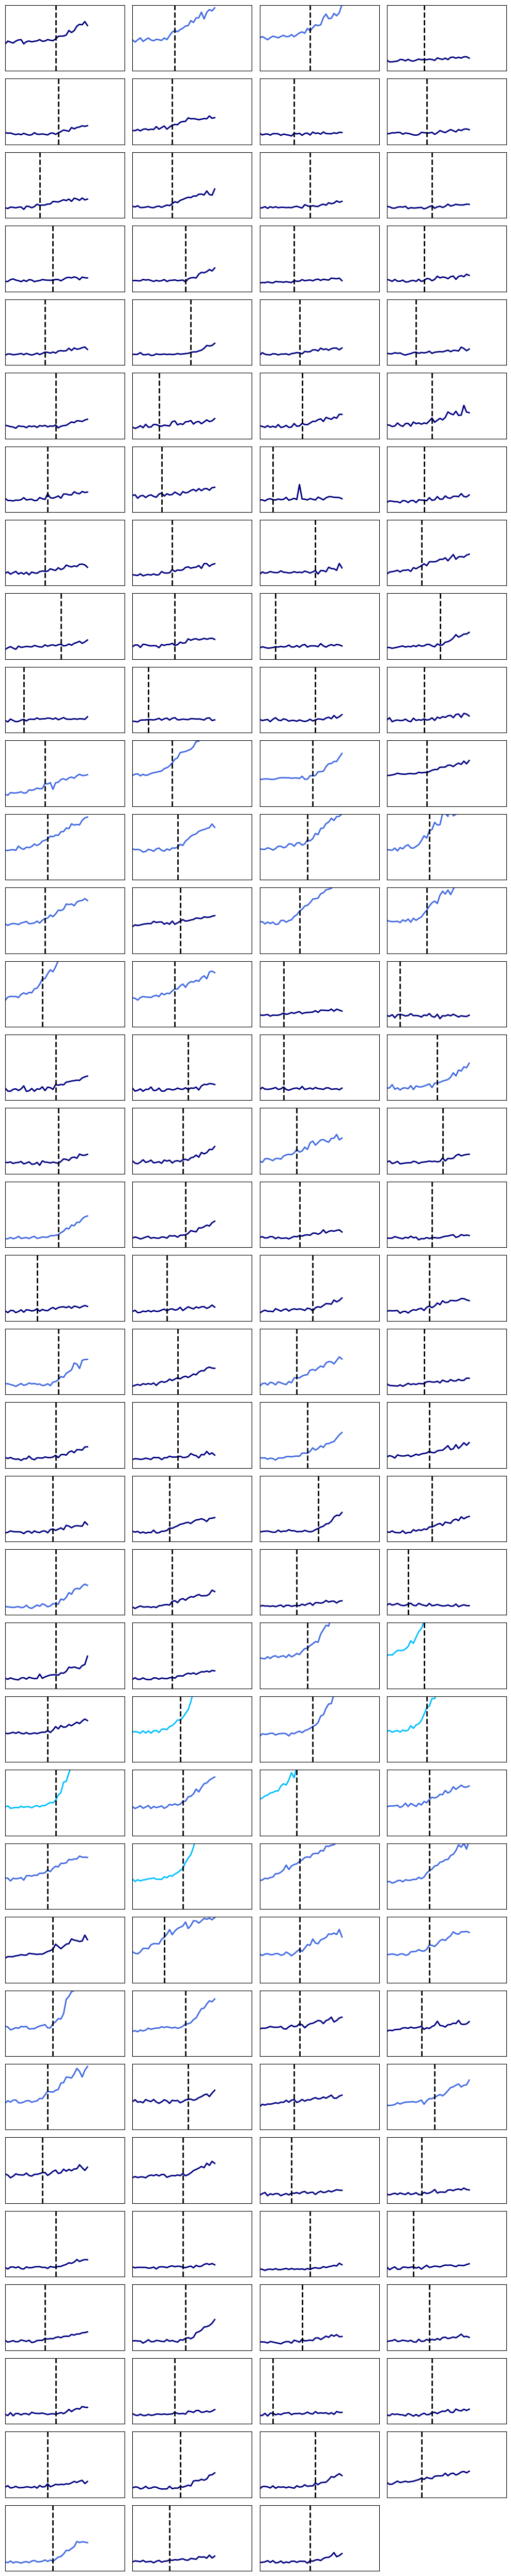

In [32]:
lag_window = 5
color = ['navy', 'deepskyblue', 'royalblue', 'aqua']

# Define the dimensions of the subplot
n_cols =  4
n_rows = np.ceil((len(intensities_mesp_lp) + 1) / n_cols)
plot_num = 1

# Initialize the figure size
ax = plt.figure(figsize=[10,50])
onset_mesp_all = []

for i in range(len(intensities_mesp_lp)):

    X = np.zeros((len(intensities_mesp_lp[i][window:]),2))
    X[:,0] = intensities_mesp_lp[i][window:]
    X[:,1] = intensities_mesp_lp[i][:-window]
    y_pred = KMeans(n_clusters=2, n_init=100).fit_predict(X)


    ind_cut = np.where(y_pred[lag_window:]==y_pred[-1])[0]+lag_window
    onset_mesp_all.append(ind_cut[0])
    
    # Update the number of subplots    
    ax = plt.subplot(int(n_rows), n_cols, plot_num, aspect='auto')
    plot_num += 1
    
    plt.plot(intensities_mesp_lp[i], color=color[y_pred1[i]], linewidth=2)
    plt.axvline(ind_cut[0], color='black', linestyle='dashed', linewidth=2)

    plt.xticks([])
    plt.xlim([0,45])
    plt.ylim([600,1400])
    plt.yticks([])
    
plt.tight_layout()
plt.show()

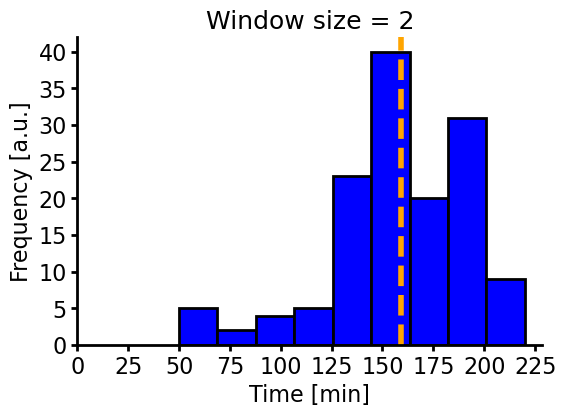

In [33]:
plt.figure(figsize=[6,4])

plt.hist(np.array(onset_mesp_all)*tr, bins='fd', linewidth=2, edgecolor='black', color='blue');
plt.xlabel('Time [min]',fontsize=16)
plt.axvline(np.mean(onset_mesp_all)*tr, color='orange', linewidth=4, linestyle='--', alpha=1)
plt.xticks(np.arange(0,250,25), np.arange(0,250,25), fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Frequency [a.u.]',fontsize=16)
plt.title('Window size = 2', fontsize=18)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

## Take only the Mesp Onsets with the highest mesp fold changes

We previously classified the Mesp fold change using K-means and we obtained 3 different groups. We are now only going to use the two groups which have the highes Mesp fold change values in order to quantify the time of this onset. 

In [34]:
# Plot all Mesp tracks for each experiment separately

# Save cropped values of intensity mesp DETRENDED - for plotting

last_peak = []

for j in range(len(cells_id)):
    
            
    # Find the last peak
    ind2 = int(last_peak_her1[j]/tr) # peaks is in minutes, convert into time frames
    stop_time = ind2+int(cut_off_val1/tr) # We have it in frames, not in minutes! 
    start_time = ind2-int(cut_off_val2/tr)

    # Check if there are enough values before and after the last peak
    if start_time>0:

        # Crop the Mesp traces
        intensities = intensities_mesp[j][start_time:stop_time]

        # Check if all the values are not nan
        if np.count_nonzero(~np.isnan(intensities)) == len_traces:

            # Last peak time
            ind = last_peak_her1[j]

            # When we start the Mesp intensities: this will be our start point
            start_time = ind-int(cut_off_val2/tr)

            # Las peak time starting from 
            last_peak.append(start_time)
                    

/var/folders/j6/1vns_r4n3q3c74_knnjh859c0000gq/T/ipykernel_4661/1990252085.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ind2 = int(last_peak_her1[j]/tr) # peaks is in minutes, convert into time frames


In [35]:
window = 5

X = np.array(ratio1_).reshape(-1, 1)
X[np.where(np.isnan(X))] = 0 # In case there is any nan
y_pred = KMeans(n_clusters=n_clusters, n_init=200, random_state=1).fit_predict(X)

# Find the maximum fold change for each group
max1 = np.max(ratio1_[np.where(y_pred==0)[0]])
max2 = np.max(ratio1_[np.where(y_pred==1)[0]])
max3 = np.max(ratio1_[np.where(y_pred==2)[0]])

# Find the two groups where the fold change is highest
inds = np.argsort([max1,max2,max3])[1:]

# Find the positions where those values are in the ratio
ind_mesp = np.concatenate((np.where(y_pred==inds[0])[0], \
                           np.where(y_pred==inds[1])[0]))

onset_mesp = []
last_peak_mesp = []

for i in ind_mesp:

    X = np.zeros((len(intensities_mesp_lp[i][window:]),2))
    X[:,0] = intensities_mesp_lp[i][window:]
    X[:,1] = intensities_mesp_lp[i][:-window]
    y_pred = KMeans(n_clusters=2, n_init=100).fit_predict(X)

    ind_cut = np.where(y_pred[window:]==y_pred[-1])[0]+window
    onset_mesp.append(ind_cut[0]*tr)
    last_peak_mesp.append(last_peak_lp[i])

## Her1 last peak distributions

In order to have all the traces of the same length and be able to compare timings, we will use the *start-time* we used for the Mesp traces as our zero time, and then we will see how far away from that point is the her 1 last peak. To better understand how these distributions were computed, the following sketch shows which part of the traces were used.

<img src="../Data/Figure 2/Figure 2 - In vitro/Her1LastPeakvsMespOnset-sketch.png">

#### Plot her 1 last peak distribution  

Her1 mean last peak time: 308


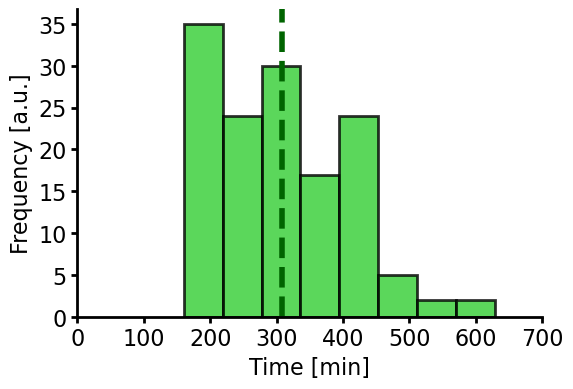

In [36]:
last_peak_lp = [item for sublist in last_peak for item in sublist]

fig = plt.figure(figsize=[6,4])
plt.hist(last_peak_lp, bins='fd', linewidth=2, edgecolor='black', color='limegreen', alpha=0.8, density=False);

# Mean values plotted as dashed lines
plt.axvline(np.mean(last_peak_lp), color='darkgreen', linewidth=4, linestyle='--', alpha=1)


print('Her1 mean last peak time: %d'%(np.mean(last_peak)))

plt.xlabel('Time [min]',fontsize=16)
plt.ylabel('Frequency [a.u.]',fontsize=16)
plt.xticks(np.arange(0,800,100), np.arange(0,800,100), fontsize=16)
plt.yticks(fontsize=16)

ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

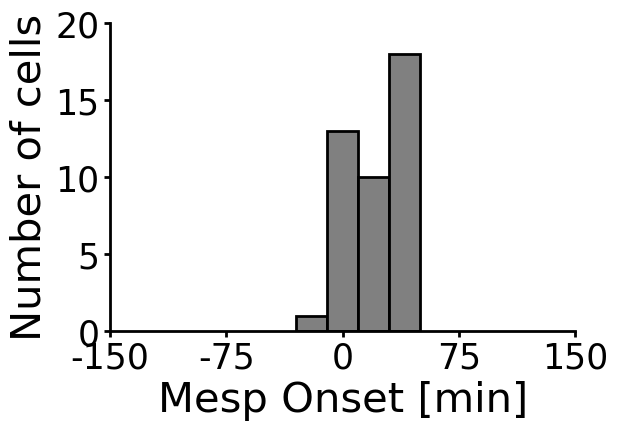

In [37]:
fig = plt.figure(figsize=[6,4])

onset_mesp = np.array(onset_mesp)

plt.hist(onset_mesp, bins='fd', linewidth=2, edgecolor='black', color='grey', alpha=1, density=False);

# Mean values plotted as dashed lines
#plt.axvline(160, color='grey', linewidth=4, linestyle='--', alpha=1)
#plt.axvline(np.mean(last_peak), color='darkgreen', linewidth=4, linestyle='--', alpha=1)


plt.xlabel('Mesp Onset [min]',fontsize=30)
plt.ylabel('Number of cells',fontsize=30)
plt.xticks(np.arange(0,330,75), np.arange(-150,180,75), fontsize=25)
plt.yticks(np.arange(0,25,5), fontsize=25)
plt.xlim([0,300])
#plt.ylim([0,1])

ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.show()
fig.savefig('../Data/Figure 2/Figure 2 - In vitro/Results/MespOnset.pdf', format='pdf', bbox_inches='tight')

## Slope Distribution

The values from the fold change mesp intensity values, we fit a line within a window and calculate the slope. 

In [38]:
slopes = []

    
for i in range(len(onset_mesp)):

    tw = onset_mesp[i]
    X = np.zeros((len(intensities_mesp_lp[i][2:]),2))
    X[:,0] = intensities_mesp_lp[i][2:]
    X[:,1] = intensities_mesp_lp[i][:-2]

    x = X[:,0].reshape(-1,1)
    y = X[:,1].reshape(-1,1)


    reg = LinearRegression().fit(x, y)
    slopes.append(reg.coef_[0][0])

#### Once trace example

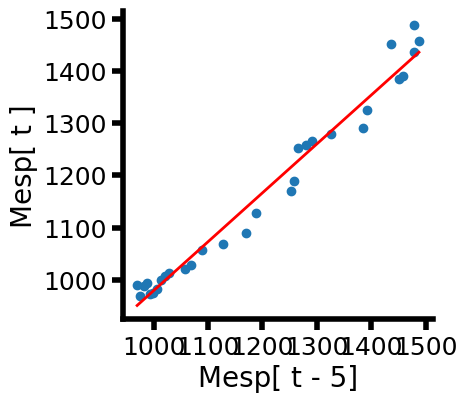

In [39]:
fig = plt.figure(figsize=[4,4])
plt.scatter(x,y)
plt.plot(np.array([np.min(x),np.max(x)]), np.array([np.min(y),np.max(y)])*reg.coef_[0]+reg.intercept_, color='red', linewidth=2)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Mesp[ t - %d]'%window, fontsize=20)
plt.ylabel('Mesp[ t ]', fontsize=20)

ax = plt.gca()
ax.tick_params(width=4, length=8)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(4)
ax.spines['left'].set_linewidth(4)
ax.spines['right'].set_linewidth(0)

plt.show()
fig.savefig('../Data/Figure 2/Figure 2 - In vitro/Results/SlopeMesp-ExampleCell.pdf', format='pdf', bbox_inches='tight')


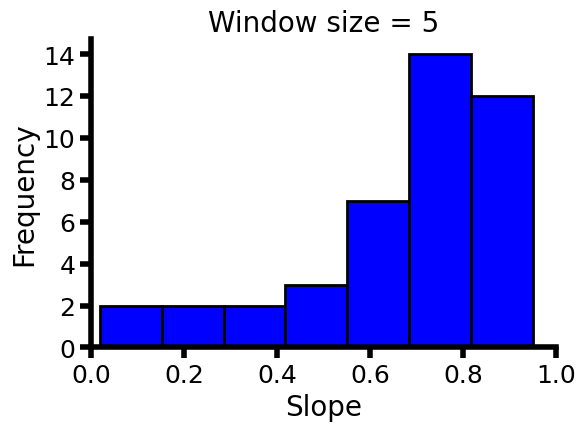

In [40]:
fig = plt.figure(figsize=[6,4])

plt.hist(slopes, bins='fd', linewidth=2, edgecolor='black', color='blue');
plt.xlabel('Slope',fontsize=20)
#plt.axvline(np.mean(onset_mesp[0]), color='orange', linewidth=4, linestyle='--', alpha=1)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim([0,1])
plt.ylabel('Frequency',fontsize=20)
plt.title('Window size = %d'%window, fontsize=20)

ax = plt.gca()
ax.tick_params(width=4, length=8)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(4)
ax.spines['left'].set_linewidth(4)
ax.spines['right'].set_linewidth(0)

plt.show()
#fig.savefig('../Data/Figure 2/Figure 2 - In vitro/Results/SlopeMespOnset-Distribution.pdf', format='pdf', bbox_inches='tight')

## Representative cell 

Show a representative cell with Her 1 intensity and Mesp intensity. 

In [41]:
example_cells = pd.read_csv('../Data/Figure 2/Figure 2 - In vitro/example_cell_fig2.csv', header=[0])
example_cells.head()

,49,49.1
0,1500.275498,965.813599
1,1392.478795,958.737723
2,1295.433136,967.648521
3,1296.332521,937.580999
4,1431.078431,947.308279


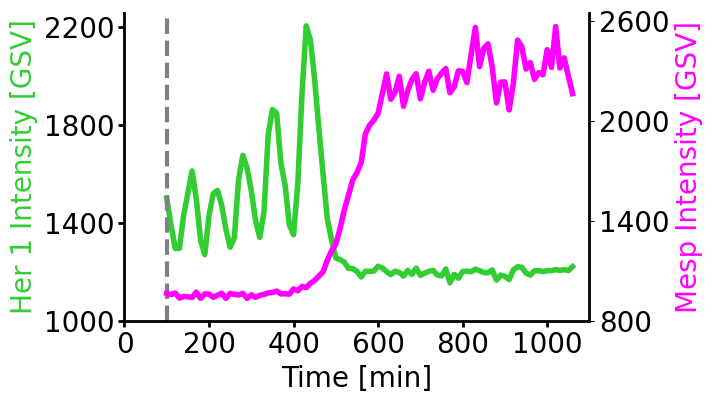

In [42]:
looping = np.array(example_cells['49'])
heidi = np.array(example_cells['49.1'])

fig,ax = plt.subplots(figsize=[6,4])
ax.plot(looping, color='limegreen',linewidth=4)
ax.set_ylabel('Her 1 Intensity [GSV]', fontsize=20, color='limegreen')
ax.tick_params(labelsize=20)
ax.set_xticks(np.arange(-10,140,20))
ax.set_xticklabels(map(int, np.arange(0,150,20)*tr))
ax.set_yticks(np.arange(1000,2500,400))

# To make a secondary Y-axis
ax2=ax.twinx()
ax2.plot(heidi, color='magenta', linewidth=4)
ax2.set_ylabel('Mesp Intensity [GSV]', fontsize=20, color='magenta')
ax2.tick_params(labelsize=20)
ax2.set_yticks(np.arange(800,3200,600))

ax.set_xlabel('Time [min]', fontsize=20)
ax.set_xlim([-10,100])
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax2.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax2.spines['right'].set_linewidth(2)

ax.axvline(0, color='grey', linewidth=3, ls='--')

plt.show()
fig.savefig('../Data/Figure 2/Figure 2 - In vitro/Results/Her1-Mesp-singlecell-invitro.pdf', format='pdf', bbox_inches='tight')

### Example for her1 last peak vs mesp

In [43]:
# Peak detection parameters
ind = 0 #8 
# Threshold
th_val = 0 # For maxima
th_val_ = 0 # For minima

# Prominence
prominence_val = 8.1 # For maxima
prominence_val_ = 8 # For minima

# Width
width_val = 2 # For maxima
width_val_ = 2 # For minima

# Distance
dist_val = 1 # For maxima
dist_val_ = 1 # For minima

# Averaging window size
window = 9

# If you want ts and as analysis: 'ts_as', ow no_ts_as
analysis = 'no_ts_as'

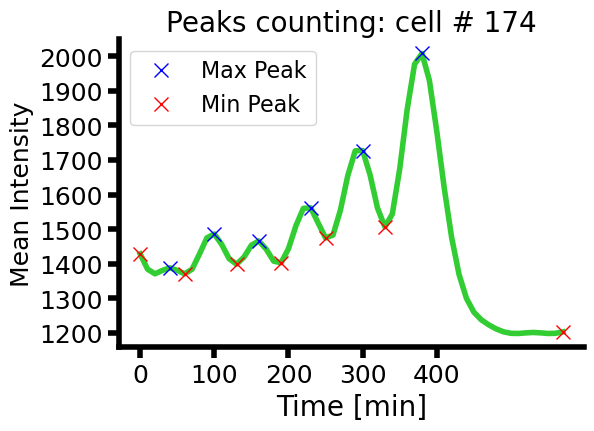

In [44]:
# Example cell
fig = plt.figure(figsize=[6,4])


looping = looping[~np.isnan(looping)][:50]
heidi = heidi[~np.isnan(heidi)][:50]

peaks = peak_detection(looping, window, th_val, th_val_, \
                       dist_val, dist_val_, prominence_val,prominence_val_, width_val, width_val_, analysis)


# Correct for the last peak in case it was not detected:
y = smoothing_filter(looping, window)



# Add a minimum in the first position of the trace (first position after the last maximum which is not a nan) in case there is no minima
if np.isnan(y[peaks.peaks_][0]):
    peaks.peaks_[0] =  np.where(np.where(np.isnan(y))[0]<peaks.peaks[0])[0][-1]+1

plt.plot(y, color='limegreen', linewidth=4)
plt.plot(peaks.peaks, y[peaks.peaks], "x", color='blue', markersize=10, label='Max Peak'); plt.plot(peaks.peaks_, y[peaks.peaks_], "xr", markersize=10, label='Min Peak');
plt.legend(fontsize=16)
plt.title('Peaks counting: cell # %d'%(j+1), fontsize = 20)
plt.xlabel('Time [min]', fontsize=20)
plt.xticks(np.arange(0,50,10), map(int,np.arange(0,50,10)*10), fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('Mean Intensity', fontsize=18)
#plt.xlim([10,200])
#plt.ylim([100,600])

ax = plt.gca()
ax.tick_params(width=4, length=8)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(4)
ax.spines['left'].set_linewidth(4)
ax.spines['right'].set_linewidth(0)

plt.show()
#fig.savefig('../Data/Figure 2/Figure 2C/ExamplePeaksDetectionCell.pdf', format='pdf', bbox_inches='tight')

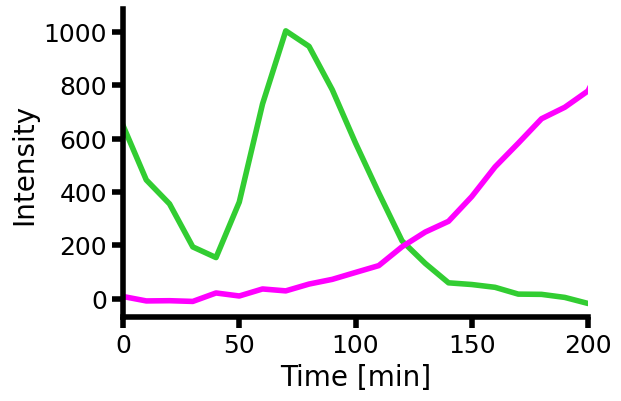

In [45]:
last_peak = int(peaks.peaks[-1]+window/2)

fig = plt.figure(figsize=[6,4])

stop_time = last_peak+int(cut_off_val1/tr) # We have it in frames, not in minutes! 
start_time = last_peak-int(cut_off_val2/tr)
            
            
looping_new = looping[start_time:stop_time]
heidi_new = heidi[start_time:stop_time]
plt.plot(looping_new-np.mean(looping_new[-5:]), color='limegreen',linewidth=4)
plt.plot(heidi_new-np.mean(heidi_new[:5]), color='magenta', linewidth=4)

plt.xlabel('Time [min]', fontsize=20)
locs, labels = plt.xticks()
plt.xticks(np.arange(0,25,5), map(int, np.arange(0,25,5)*tr), fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('Intensity', fontsize=20)
plt.xlim([0,20])
ax = plt.gca()
ax.tick_params(width=4, length=8)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(4)
ax.spines['left'].set_linewidth(4)
ax.spines['right'].set_linewidth(0)

plt.show()
fig.savefig('../Data/Figure 2/Figure 2 - In vitro/Results/Her1-Mesp-singlecell-invitro-cropped-1Cell.pdf', format='pdf', bbox_inches='tight')

### Representative cells for waterfall plot

In [46]:
representative_cells = pd.read_csv('../Data/Figure 2/Figure 2 - In vitro/Waterfall_invitrocells.csv', header=[0,1])
representative_cells.head()

Looping                                                      \
     416_16(2)    416_41(4)    416_40(6)    416_11(6)    416_47(5)   
0  1580.703620  1401.207416  1237.321789  1380.747000  1149.213828   
1  1560.554204  1305.198032  1189.777630  1376.355698  1173.826622   
2  1417.257642  1261.223131  1128.186076  1350.676600  1295.689727   
3  1287.979052  1318.219890  1113.508065  1301.206161  1335.836216   
4  1361.934054  1388.633257  1156.493622  1201.831878  1281.612669   

                      Mesp                                                  \
     416_30(6)   416_16(2)   416_41(4)   416_40(6)   416_11(6)   416_47(5)   
0  1356.627066  942.996606  937.469293  936.584416  970.361000  976.527529   
1  1524.816514  928.133850  955.060271  948.937417  961.172524  981.683445   
2  1490.190733  928.822052  936.787383  937.332911  967.747241  962.202306   
3  1434.118454  926.762955  938.952486  941.379032  966.195498  948.477111   
4  1270.554670  929.471351  935.998861  929.047194  948.658297  951.516096   

               
    416_30(6)  
0  933.184917  
1  962.813073  
2  951.705819  
3  952.481297  
4  935.916856

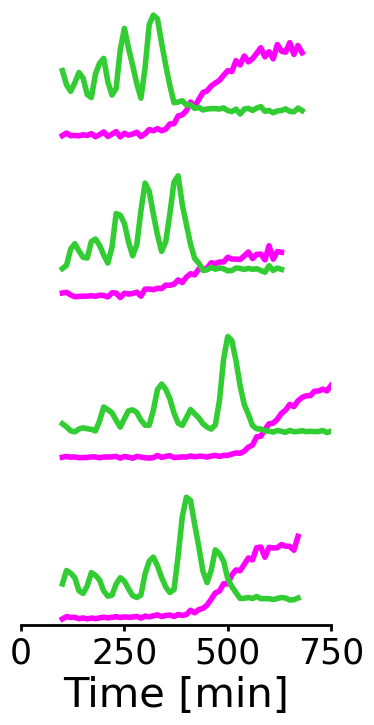

In [47]:
looping = representative_cells['Looping']
mesp = representative_cells['Mesp']
n_cells = len(looping.keys())

fig = plt.figure(figsize=[4,8])

cells = [1,4,2,5]
first_vall = [0,5,0,0]
first_valm = [40,40,50,40]
for i,val in enumerate(cells):
    
    ax = plt.subplot(int('%d'%len(cells)),1,i+1)
    
    init_mesp = mesp[mesp.keys()[val]][first_valm[i]]
    max_mesp = np.max(mesp[mesp.keys()[val]]-init_mesp)
    
    plt.plot((mesp[mesp.keys()[val]]-init_mesp), linewidth=4, color='magenta')
    
    init_loop = looping[looping.keys()[val]][first_vall[i]]
    max_loop = np.max(looping[looping.keys()[val]]-init_loop)
    
    plt.plot((looping[looping.keys()[val]]-init_loop), linewidth=4, color='limegreen')
    #plt.xlim([0,200])
    if i==len(cells)-1:
        plt.xticks(np.arange(-10,70,25), map(int,np.arange(0,80,25)*10), fontsize=25)
        top_side = ax.spines["top"]
        top_side.set_visible(False)
        left_side = ax.spines["left"]
        left_side.set_visible(False)
        right_side = ax.spines["right"]
        right_side.set_visible(False)
        ax.spines['bottom'].set_linewidth(2)
        ax.xaxis.set_tick_params(width=2, length=4)
        plt.yticks([])
        plt.xlabel('Time [min]', fontsize=30)
        
    else:
        plt.xticks([])
        plt.axis('off')
    
    plt.xlim([-10,65])
    
    
fig.savefig('../Data/Figure 2/Figure 2 - In vitro/Results/LoopingMesp-waterfall.pdf')

## Successive Peak Ratio vs Successive Amplitude Ratio

In [48]:
successive_period = pd.read_excel('../Data/Figure 2/Figure 2 - In vitro/Fig2_MaxInt&PeriodSucesiveRatio_checked.xlsx', 
                                sheet_name='Period Successive Ratios', header=[1,2])
successive_period.head()

Experiment       419                                              \
  Cell Position        41  43        47        48        54        56   
0   cycle 2 / 1  1.240965 NaN  1.077558  0.806463  1.104773  1.331926   
1     cycle 3/2  1.215691 NaN  1.207229  1.575845  1.142003  1.061466   
2     cycle 4/3  1.102287 NaN       NaN  0.921607       NaN       NaN   
3     cycle 5/4  1.143218 NaN       NaN  1.166043       NaN       NaN   
4     cycle 6/5       NaN NaN       NaN       NaN       NaN       NaN   

                           ...       453                                \
         68        70  73  ...        25        26        27        29   
0  1.094687  1.127732 NaN  ...  1.290985  1.057834  0.936142  0.994097   
1       NaN       NaN NaN  ...  1.003052  1.016947       NaN  1.004252   
2       NaN       NaN NaN  ...  1.118174  1.243114       NaN  1.296342   
3       NaN       NaN NaN  ...       NaN  1.017644       NaN  1.238767   
4       NaN       NaN NaN  ...       NaN       NaN       NaN  0.830081   

                                                               
         33        34        35        36        38        39  
0  1.123847  0.990214  1.172602  1.508959  0.881187  1.299518  
1  1.004736  1.146637  1.137207       NaN  1.569998       NaN  
2  1.162273  1.163856  1.157516       NaN  1.049723       NaN  
3  1.107472  1.085171  1.072567       NaN       NaN       NaN  
4       NaN       NaN       NaN       NaN       NaN       NaN  

[5 rows x 185 columns]

In [49]:
successive_amplitude = pd.read_excel('../Data/Figure 2/Figure 2 - In vitro/Fig2_MaxInt&PeriodSucesiveRatio_checked.xlsx', 
                                sheet_name='Max Intensity Successive Ratios', header=[1,2])
successive_amplitude.head()

Experiment       419                                              \
  Cell Position        41  43        47        48        54        56   
0   cycle 2 / 1  1.115500 NaN  0.976719  1.153422  1.115653  1.244831   
1     cycle 3/2  1.434921 NaN  1.267134  1.609029  1.251691  1.106425   
2     cycle 4/3  1.183838 NaN  1.246998  0.726516  1.283291  1.202515   
3     cycle 5/4  0.744010 NaN       NaN  1.144704       NaN       NaN   
4     cycle 6/5  1.113214 NaN       NaN  1.115194       NaN       NaN   

                           ...       453                                \
         68        70  73  ...        25        26        27        29   
0  0.984166  1.108195 NaN  ...  1.043504  1.051305  1.118414  1.057062   
1  1.069169  1.230624 NaN  ...  1.192316  0.981030  0.909994  1.122493   
2       NaN       NaN NaN  ...  0.977563  1.070788       NaN  1.032070   
3       NaN       NaN NaN  ...  0.806189  0.928743       NaN  0.997978   
4       NaN       NaN NaN  ...       NaN  1.065466       NaN  1.206960   

                                                               
         33        34        35        36        38        39  
0  0.972667  1.022080  1.109777  1.177080  1.166542  1.011013  
1  1.242122  0.922128  0.915513  1.271947  0.983015  1.036272  
2  1.045597  1.027626  0.970757       NaN  1.109203       NaN  
3  0.943795  1.022331  1.093524       NaN  0.903064       NaN  
4  1.068116  1.320879  0.977448       NaN       NaN       NaN  

[5 rows x 185 columns]

### Rearrange the data by cell

In [50]:
cells_period_ratio = []
cells_amplitude_ratio = []
for i in range(len(cells_id)):
    aux = successive_period[experiments_id[i]][cells_id[i]].dropna().to_numpy()
    if np.size(aux)>0:
        cells_amplitude_ratio+=list(successive_amplitude[experiments_id[i]][cells_id[i]].dropna().to_numpy())
        cells_period_ratio+=list(aux)

In [51]:
n_cells

6

### Plot the results

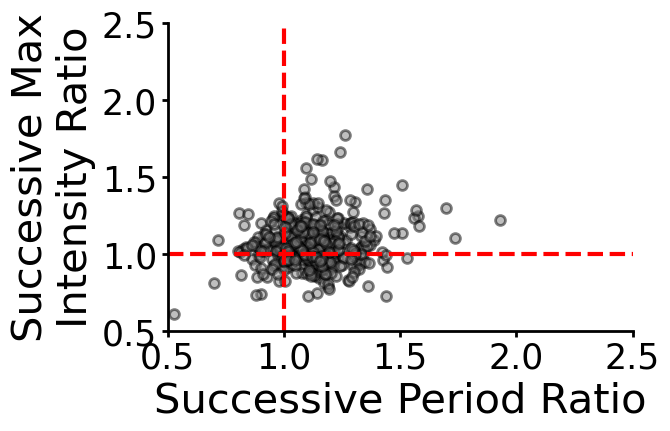

In [52]:
fig = plt.figure(figsize=[6,4])
n_cells = len(cells_period_ratio)

for i in range(n_cells):
    plt.scatter(cells_period_ratio[i], cells_amplitude_ratio[i], color='gray', s=50, linewidth=2, edgecolor='black', alpha=0.5)
        
plt.axvline(1, linewidth=3, linestyle='dashed', color='red')
plt.axhline(1, linewidth=3, linestyle='dashed', color='red')

plt.xlim([0.5,2.5])
plt.ylim([0.5,2.5])
plt.xticks(np.arange(0.5,3, 0.5), fontsize=25)
plt.yticks(np.arange(0.5,3, 0.5),fontsize=25)

plt.xlabel('Successive Period Ratio', fontsize=30)
plt.ylabel('Successive Max\nIntensity Ratio', fontsize=30)

ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.show()

fig.savefig('../Data/Figure 2/Figure 2 - In vitro/Results/SuccessivePeriod-Amplitude.pdf', format='pdf', bbox_inches='tight')


In [53]:
ratio1 = 0
n_cycles = 0
for i in range(n_cells):
        n_cycles +=1
        if cells_amplitude_ratio[i]>=1 and cells_period_ratio[i]>=1:
            ratio1 += 1
            
        
print('There are %d cycles that slow down from %d total.'%(ratio1, n_cycles))
print('The proportion is: %d '%((ratio1/n_cycles)*100))

There are 235 cycles that slow down from 421 total.
The proportion is: 55 


### Successive period and intensity ratio - KDE

In [54]:
cells_period_ratio = []
cells_amplitude_ratio = []
for i in range(len(cells_id)):
    aux = successive_period[experiments_id[i]][cells_id[i]].dropna().to_numpy()
    if np.size(aux)>0:
        cells_amplitude_ratio+=list(successive_amplitude[experiments_id[i]][cells_id[i]].dropna().to_numpy()[:-1])
        cells_period_ratio+=list(aux)

In [55]:
from scipy.stats import kde
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [56]:
x = []
y = []

xy_min = 0.5
xy_max = 2
step = 0.5

# Convert into array
x = np.array(cells_period_ratio)
y = np.array(cells_amplitude_ratio)
        
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins = 300
k = kde.gaussian_kde([x,y])
#xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
xi, yi = np.mgrid[xy_min:xy_max:nbins*1j, xy_min:xy_max:nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

/var/folders/j6/1vns_r4n3q3c74_knnjh859c0000gq/T/ipykernel_4661/2077085208.py:14: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  k = kde.gaussian_kde([x,y])


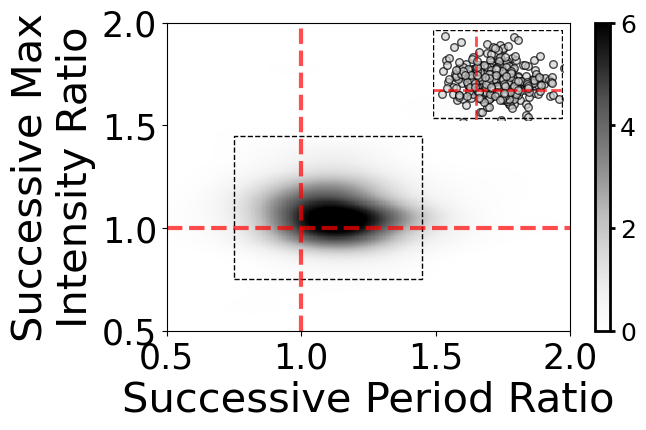

In [57]:
fig = plt.figure(figsize=[6.5, 4])
ax = fig.add_subplot(111)
# Create inset of width 1.3 inches and height 0.9 inches
# at the default upper right location

mesh = ax.pcolormesh(xi, yi, zi.reshape(xi.shape), 
               shading='auto', cmap='Greys', vmin=0, vmax=6)

axins = inset_axes(ax, width=1.3, height=0.9)

for i in range(n_cells):
    axins.scatter(cells_period_ratio[i], cells_amplitude_ratio[i], color='lightgrey', s=30, linewidth=1, edgecolor='black', alpha=0.7)
    count += 1
        
axins.axis('off')
axins.set_xlim([0.75, 1.5])
axins.set_ylim([0.75, 1.5])
        
# Colorbar
cb = plt.colorbar(mesh, ax=ax)
cb.outline.set_linewidth(2)
cb.set_ticks(np.arange(0,7,2))
cb.set_ticklabels(np.arange(0,7,2), fontsize=18)
cb.ax.tick_params(width=2)

x_rect = 0.75
y_rect = 0.75
width = 0.70
height = 0.70
ax.add_patch(plt.Rectangle((x_rect, y_rect), width, height,
                           ls="--", ec="k", fc="none"))

x_rect = 0.75
y_rect = 0.76
width = 0.745
height = 0.74
axins.add_patch(plt.Rectangle((x_rect, y_rect), width, height,
                           ls="--", ec="k", fc="none"))

# Axes
ax.axvline(1, linewidth=3, linestyle='dashed', color='red', alpha=0.7)
ax.axhline(1, linewidth=3, linestyle='dashed', color='red', alpha=0.7)

axins.axvline(1, linewidth=2, linestyle='dashed', color='red', alpha=0.7)
axins.axhline(1, linewidth=2, linestyle='dashed', color='red', alpha=0.7)

ax.set(xlim=(xy_min,xy_max), ylim=(xy_min,xy_max))
ax.set_xticks(np.arange(xy_min,xy_max+step, step))
ax.set_yticks(np.arange(xy_min,xy_max+step, step))
ax.set_xticklabels(np.arange(xy_min,xy_max+step, step), fontsize=25)
ax.set_yticklabels(np.arange(xy_min,xy_max+step, step), fontsize=25)

ax.set_xlabel('Successive Period Ratio', fontsize=30)
ax.set_ylabel('Successive Max\nIntensity Ratio', fontsize=30)

ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.show()




fig.savefig('../Data/Figure 2/Figure 2 - In vitro/Results/SuccessivePeriod-Amplitude-KDE_invitro.pdf', format='pdf', bbox_inches='tight')

In [58]:
ratio1 = 0
n_cycles = len(cells_amplitude_ratio)

for i in range(n_cells):
    if cells_amplitude_ratio[i]>=1 and cells_period_ratio[i]>=1:
        ratio1 += 1
            
        
print('There are %d cycles that slow down from %d total.'%(ratio1, n_cycles))
print('The proportion is: %d '%((ratio1/n_cycles)*100))

There are 242 cycles that slow down from 421 total.
The proportion is: 57 
